# Fitting a model to data

In this recipe we will demonstrate how to fit a simple model, namely a line, to some data. Although this example is simple, it illustrates what is the proper way of fitting our models to data and infering the parameters of the models.

Let us first import the main packages that we will use:

In [1]:
# show plots inline in the notebook
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display, Math

import zeus

## The generative probabilistic model

In order to create our *synthetic* data we need to construct a *generative probabilistic model*.

We start by defining the *straight line* model and also setting the *true values* of the model parameters:

In [2]:
# define the model function
def straight_line(x, m, c):
    ''' A straight line model: y = m*x + c '''
    return m*x + c

# set the true values of the model parameters for creating the data
m_true = 3.5 # gradient of the line
c_true = 1.2 # y-intercept of the line

# Set the x-coordinates of the data points
M = 70 # Number of data points
x = np.sort(10.0 * np.random.rand(M)) # their x-coordinates

We are now ready to generate the synthetic data. To this end, we evaluate the model function at the *true values* of *m (slope)* and *c (y-intercept)* and we add some random *Gaussian* noise of known amplitude *sigma*.

In [3]:
# create the data - the model plus Gaussian noise
sigma = 3.0 # standard deviation of the noise
data = straight_line(x, m_true, c_true) + sigma * np.random.randn(M)

We can also plot the generative model and the data:

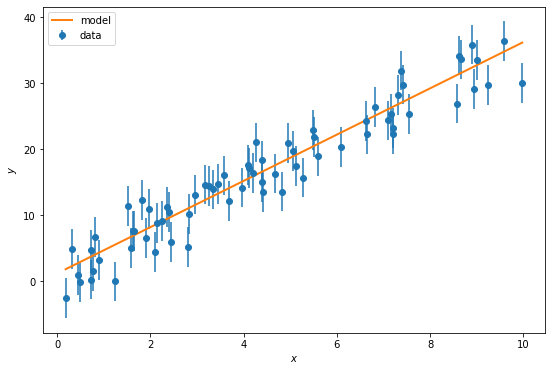

In [4]:
plt.figure(figsize=(9,6))
plt.errorbar(x, data, yerr=sigma, fmt="o", label='data')
plt.plot(x, straight_line(x, m_true, c_true), '-', lw=2, label='model')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

## The likelihood, prior, and posterior distributions

The first step to solve a problem is generally to write down the prior and likelihood functions. An important benefit of MCMC is that none of these probability densities need to be normalised.

Here we'll start with the natural logarithm of the prior probability: 

In [5]:
def logprior(theta):
    ''' The natural logarithm of the prior probability. '''

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 3.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2

    return lp

We assume that the likelihood is *Gaussian (Normal)*:

In [6]:
def loglike(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''
    
    # unpack the model parameters
    m, c = theta

    # evaluate the model
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5 * np.sum(((md - data)/sigma)**2)

The log posterior is just the sum of the log prior and the log likelihood probability density functions:

In [7]:
def logpost(theta, data, sigma, x):
    '''The natural logarithm of the posterior.'''
    
    return logprior(theta) + loglike(theta, data, sigma, x)

## Sampling the posterior using *zeus*

We initialize and run zeus to sample from the posterior distribution. Thin only takes a few lines of code.

In [8]:
ndim = 2 # Number of parameters/dimensions (e.g. m and c)
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 2000 # Number of steps/iterations.

start = 0.01 * np.random.randn(nwalkers, ndim) # Initial positions of the walkers.

sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, args=[data, sigma, x]) # Initialise the sampler
sampler.run_mcmc(start, nsteps) # Run sampling
sampler.summary # Print summary diagnostics

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 2000/2000 [00:08<00:00, 237.71it/s, nexp=0.8, ncon=1.4]
Summary
-------
Number of Generations: 2000
Number of Parameters: 2
Number of Walkers: 10
Number of Tuning Generations: 24
Scale Factor: 3.03521
Mean Integrated Autocorrelation Time: 3.02
Effective Sample Size: 6629.56
Number of Log Probability Evaluations: 104165
Effective Samples per Log Probability Evaluation: 0.063645


## Results

Lets plot the chains. We can see that the burn-in phase is very brief.

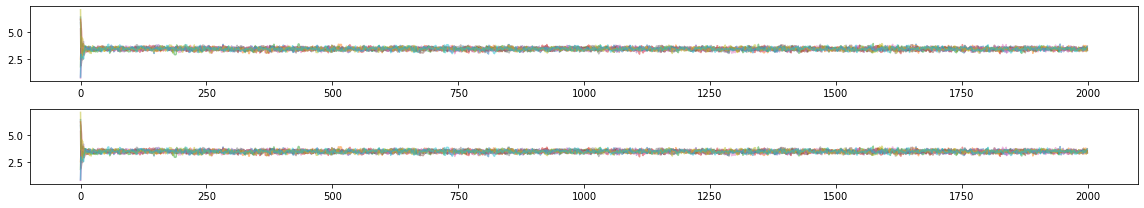

In [9]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,0], alpha=0.5)
plt.tight_layout()
plt.show()

We discard the first half of the chain elements, thin the samples by a factor of 10, and flatten the resulted chain. We then proceed to plot the marginal posterior distributions:

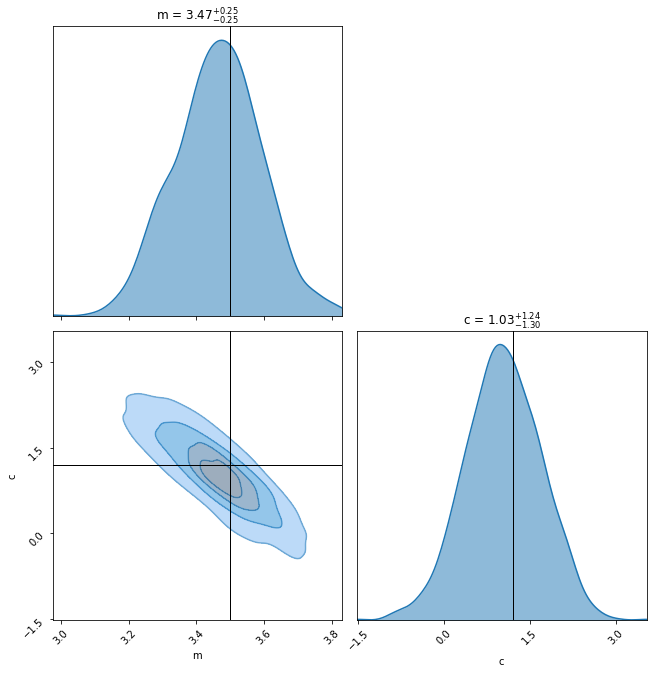

In [11]:
# flatten the chains, thin them by a factor of 10, and remove the burn-in (first half of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//2, thin=10)

# plot marginal posterior distributions
fig, axes = zeus.cornerplot(chain, labels=['m', 'c'], truth=[m_true, c_true]);

Now lets plot the projection of our results into the space of the observed data. The easiest way to do this is to randomly select 100 samples from the chain and plot the respective models on top the data points.

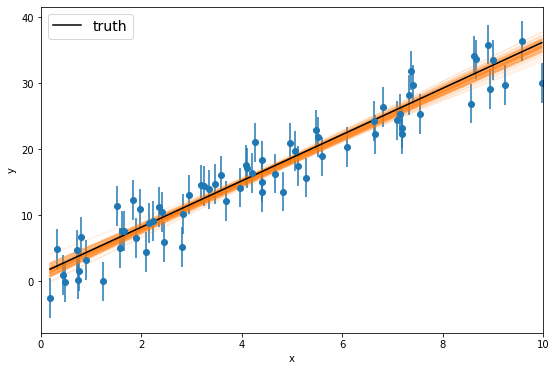

In [12]:
inds = np.random.randint(len(chain), size=100)
plt.figure(figsize=(9,6))
for ind in inds:
    sample = chain[ind]
    plt.plot(x, np.dot(np.vander(x, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, data, yerr=sigma, fmt="o")
plt.plot(x, straight_line(x,m_true,c_true), 'k', label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

And finally we will print the *maximum a posteriori (MAP)* estimate along with the *1-sigma* uncertainty for the model parameters:

In [13]:
labels=['m','c']
for i in range(ndim):
    mcmc = np.percentile(chain[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>